## Test the different datasets to check which one is better

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import os
import math
import h5py

# import data

In [92]:
def fix_mat(data):
    if data.dtype.names:
        new_data = dict()
        for name in data.dtype.names:
            new_data[name]=data[0][name][0]
        for k,v in new_data.items():
            if v.dtype.names:
                new_data[k] = fix_mat(v)
            else:
                new_data[k] = np.squeeze(v)
        return new_data
    else:
        return data

In [109]:
subject = 'c7'
day = '20250131'
path = '/home/paolo/cvsa_ws/record/' + subject + '/' + day + '/calibration/set/'
file_dataset = ['features_matlab.mat', 'features_matlab_difference.mat', 'features_ros.mat', 
                'features_ros_difference.mat']

In [96]:
path + '' + file_dataset[loading_file]

'/home/paolo/cvsa_ws/record/c7/20250131/calibration/set/features_matlab.mat'

In [110]:
loading_file = 0
data = loadmat(path + '' + file_dataset[loading_file])

X = fix_mat(data['X'])
y = fix_mat(data['y']).ravel()
info = fix_mat(data['information'])

In [98]:
info['startNewFile']

array([     0,  37931, 110931, 184097], dtype=int32)

In [111]:
# start using last n-1 files as test set
n = 1
start_test = info['startNewFile'][-n] - 1

X_train = X[:start_test,:]
y_train = y[:start_test].ravel()
X_test = X[start_test:,:]
y_test = y[start_test:].ravel()

print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (184096, 17) (184096,)
Test set: (71887, 17) (71887,)


# Usefull functions

In [90]:
def print_cm(cm, title, tick_labels):

    # Create a heatmap
    plt.figure(figsize=(3,2))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)
    
    # Add labels and titles
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()
    

def print_cm_rej(model, X, y_true, th_rej, title, ticket_label):
    cm = [[0, 0], [0, 0]]
    y_probs = model.predict_proba(X)
    count_integrated = 0
    count_NOTintegrated = 0
    
    for idx_p in range(len(y_probs)):
        if y_true[idx_p] == 730 and y_probs[idx_p,0] > th_rej:
            cm[0][0] += 1 
            count_integrated = count_integrated + 1
        elif y_true[idx_p] == 730 and y_probs[idx_p, 1] > th_rej:
            cm[0][1] += 1
            count_integrated = count_integrated + 1
        elif y_true[idx_p] == 731 and y_probs[idx_p, 1] > th_rej:
            cm[1][1] += 1
            count_integrated = count_integrated + 1
        elif y_true[idx_p] == 731 and y_probs[idx_p, 0] > th_rej:
            cm[1][0] += 1
            count_integrated = count_integrated + 1
    
    # print accuracy
    print('Accuracy:', np.trace(cm)/np.sum(cm))
    print('Accuracy 730:', cm[0][0]/(cm[0][0]+cm[0][1]))
    print('Accuracy 731:', cm[1][1]/(cm[1][0]+cm[1][1]))
    print('Integrated: ', count_integrated, ' percentual: ', count_integrated/len(y_probs), '%')   
    print_cm(cm, title, ticket_label)
    
def accuracy_online(prob, hit, miss, timeout, target, ths):
        
    i1 = np.where(prob[:,0] > ths[0])[0]
    if len(i1) == 0:
        i1 = len(prob[:,0]) + 1
    else:
        i1 = i1[0]
    i2 = np.where(prob[:,0] < ths[1])[0]
    if len(i2) == 0:
        i2 = len(prob[:,0]) + 1
    else:
        i2 = i2[0]
        
        
    
    if (target == 730 and i1 < i2) or (target == 731 and i1 > i2):
        hit += 1
    elif (target == 730 and i1 > i2) or (target == 731 and i1 < i2):
        miss += 1
    elif i1 == i2:
        timeout += 1
        
    return hit, miss, timeout
    
def histo_prediction(X, model, nbins, classes):
    probs = model.predict_proba(X)
    figure = plt.figure(figsize=(5, 3))
    plt.hist(probs[:,0], bins=nbins)
    # Add title and labels
    plt.title('Probability Distribution of class ' + classes[0])
    plt.xlabel('Probability')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()
    

In [26]:
def online_test_exponential(model, X, y, alpha, ths, th_rej):
    # look only test data
    %matplotlib widget
    y_inter = 0.5
    tmp = info['trialStart']
    cfStart = tmp[tmp >= start_test] - start_test
    cfDUR = info['trialDUR'].ravel()
    cfDUR = cfDUR[tmp >= start_test]
    
    maxDUR = np.max(cfDUR)
    

    fig, axs = plt.subplots(math.ceil(len(cfStart)/4), 4, sharex=True, sharey=True)
    fig.set_size_inches(15,10)

    hit, miss, timeout = 0, 0, 0

    # iteration over trials
    for i in range(len(cfStart)):
        
        c_start = cfStart[i]
        c_end = c_start + cfDUR[i]
        
        c_y = np.array([[y_inter, y_inter]])
        probs = model.predict_proba(X[c_start:c_end,:])
        pred = model_qda.predict(X[c_start:c_end,:])
        pred[pred==731]=0
        pred[pred==730]=1
        
        for prob in probs:
            if max(prob) > th_rej:
                c_t = alpha * c_y[-1,:] + (1 - alpha) * prob
                c_y = np.vstack([c_y, c_t])
            else:
                c_t = c_y[-1,:]
                c_y = np.vstack([c_y, c_t])
        
        prev_hit = hit
        prev_miss = miss
        prev_timeout = timeout
        [hit, miss, timeout] = accuracy_online(c_y, hit, miss, timeout, y[cfStart[i]], ths)
        
        axs[int(i/4), i%4].plot(c_y[:,0]) # first column is about 730 
        axs[int(i/4), i%4].scatter(range(len(pred)), pred, color='black')
        axs[int(i/4), i%4].hlines(y_inter, 0, len(c_y), colors='r')
        axs[int(i/4), i%4].set_xlim([0, maxDUR])
        axs[int(i/4), i%4].set_xticks(np.arange(0, maxDUR, 8))
        axs[int(i/4), i%4].set_xticklabels(np.arange(0, maxDUR, 8)/16.0)
        if hit-prev_hit != 0:
            c_title = f'{y[cfStart[i]]} hit'
        elif miss - prev_miss != 0:
            c_title = f'{y[cfStart[i]]} miss'
        elif timeout - prev_timeout != 0:
            c_title = f'{y[cfStart[i]]} timeout'
        axs[int(i/4), i%4].set_title(c_title)
    
    print(f'Online accuracy: {hit/(hit+miss+timeout)}, hit: {hit}, miss: {miss}, timeout: {timeout}')
    
    plt.tight_layout()
    plt.show()

In [27]:
def online_test_integrator_buffer(model, X, y, buffer_size, ths): # TODO: generalize for not intial percentual = 0.5

    # look only test data
    %matplotlib widget
    y_inter = 0.5
    tmp = info['trialStart']
    cfStart = tmp[tmp >= start_test] - start_test
    cfDUR = info['trialDUR'].ravel()
    cfDUR = cfDUR[tmp >= start_test]

    maxDUR = np.max(cfDUR)

    fig, axs = plt.subplots(math.ceil(len(cfStart)/4), 4, sharex=True, sharey=True)
    fig.set_size_inches(15,10)
    hit, miss, timeout = 0, 0, 0
    # iteration over trials
    for i in range(len(cfStart)):

        buffer = np.array([730 if i % 2 == 0 else 731 for i in range(buffer_size)])

        c_start = cfStart[i]
        c_end = c_start + cfDUR[i]

        c_y = np.array([[0.5, 0.5]])
        pred = model.predict(X[c_start:c_end,:])
        pred_prob = pred.copy()
        pred_prob[pred==731]=0
        pred_prob[pred==730]=1

        index = 0
        for j in range(len(pred)):
            if index == buffer_size:
                index = 0
            buffer[index] = pred[j]
            # compute percentual values
            c_y = np.vstack([c_y, [np.sum(buffer == 730)/buffer_size, np.sum(buffer == 731)/buffer_size]])
            index = index + 1

        prev_hit = hit
        prev_miss = miss
        prev_timeout = timeout
        [hit, miss, timeout] = accuracy_online(c_y, hit, miss, timeout, y[cfStart[i]], ths)

        axs[int(i/4), i%4].plot(c_y[:,0]) # first column is about 730 
        axs[int(i/4), i%4].scatter(range(len(pred_prob)), pred_prob, color='black')
        axs[int(i/4), i%4].hlines(y_inter, 0, len(c_y), colors='r')
        axs[int(i/4), i%4].set_xlim([0, maxDUR])
        axs[int(i/4), i%4].set_xticks(np.arange(0, maxDUR, 16))
        axs[int(i/4), i%4].set_xticklabels(np.arange(0, maxDUR, 16)/16.0)
        if hit-prev_hit != 0:
            c_title = f'{y[cfStart[i]]} hit'
        elif miss - prev_miss != 0:
            c_title = f'{y[cfStart[i]]} miss'
        elif timeout - prev_timeout != 0:
            c_title = f'{y[cfStart[i]]} timeout'
        axs[int(i/4), i%4].set_title(c_title)

    print(f'Online accuracy: {hit/(hit+miss+timeout)}, hit: {hit}, miss: {miss}, timeout: {timeout}')

    plt.tight_layout()
    plt.show()

# QDA

In [112]:
param_grid = {'reg_param': [0.0, 0.1, 0.5, 1.0], 'priors': [None, [0.5, 0.5]]}

#grid_search = GridSearchCV(estimator=QuadraticDiscriminantAnalysis(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=3).fit(X_train, y_train)
grid_search = GridSearchCV(estimator=QuadraticDiscriminantAnalysis(), param_grid=param_grid, cv=5, n_jobs=-1).fit(X, y)

#print("Results: ", grid_search.cv_results_)
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Best parameters found:  {'priors': None, 'reg_param': 0.1}
Best score found:  0.5972742677804113


In [113]:
model_qda = QuadraticDiscriminantAnalysis(reg_param=grid_search.best_params_['reg_param'], store_covariance=True, priors=grid_search.best_params_['priors'])
model_qda.fit(X_train, y_train)

print(f'Accuracy train: {model_qda.score(X_train, y_train)}')
print(f'Accuracy test:  {model_qda.score(X_test, y_test)}')
print(f'Accuracy all:   {model_qda.score(X, y)}')

Accuracy train: 0.629274943507735
Accuracy test:  0.611028419602988
Accuracy all:   0.6241508225155576


In [58]:
# train over all the dataset
model_qda = QuadraticDiscriminantAnalysis(reg_param=grid_search.best_params_['reg_param'], store_covariance=True, priors=grid_search.best_params_['priors'])
model_qda.fit(X, y)

print(f'Accuracy all:   {model_qda.score(X, y)}')

Accuracy all:   0.6173808416965189


Accuracy: 0.629274943507735
Accuracy 730: 0.45978394244881265
Accuracy 731: 0.7688125185698722
Integrated:  184096  percentual:  1.0 %


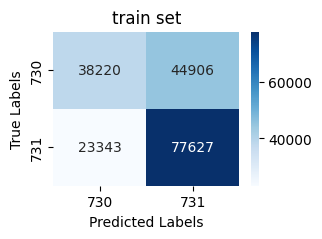

Accuracy: 0.611028419602988
Accuracy 730: 0.41937145801133435
Accuracy 731: 0.8360298787310612
Integrated:  71887  percentual:  1.0 %


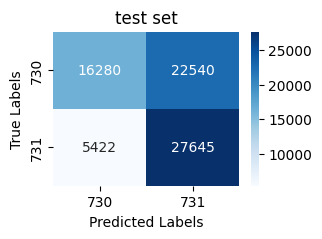

Accuracy: 0.6241508225155576
Accuracy 730: 0.44691912813868434
Accuracy 731: 0.7853950774786067
Integrated:  255983  percentual:  1.0 %


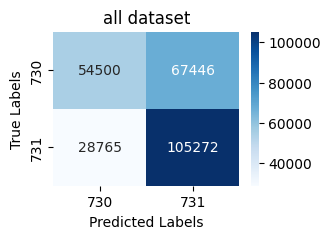

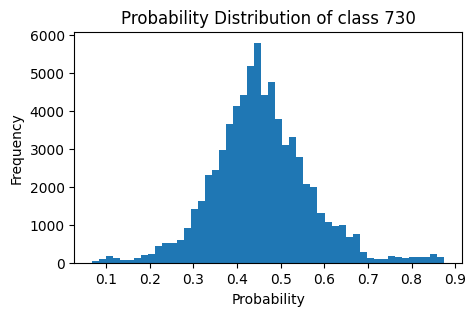

In [114]:
print_cm_rej(model_qda, X_train, y_train, 0.5, 'train set',  ['730', '731'])
print_cm_rej(model_qda, X_test,  y_test,  0.5, 'test set',  ['730', '731'])
print_cm_rej(model_qda, X,  y,  0.5, 'all dataset',  ['730', '731'])

histo_prediction(X_test, model_qda, nbins=50, classes=['730', '731'])

# Save QDA

In [22]:
# save qda model for sklearn
from ruamel.yaml import YAML
from ruamel.yaml.scalarstring import LiteralScalarString

features_label = []
for i in range(0, len(info['selchs'].tolist())):
    for j in range(0, len(info['selchs'].tolist()[i])):
        for k in range(0, len(info['selchs'].tolist()[i][j])):
            if info['selchs'].shape == ():
                str_ch = info['selchs'].tolist()[i][j][k]
            else:
                str_ch = info['selchs'][i][j][k][0]
            features_label.append(str(str_ch))

files = []
for i in range(0, len(info['files'])):
    str_file = info['files'][i][0]
    files.append(str(str_file))
    
band = info['band'].tolist()
id_ch = info['idx_selchs'].tolist()

model_params = {
    'QdaCfg': {
        'name': "qda",
        'params': {
            'subject': subject,
            'filename': 'qda',
            'filename_dataset': path,
            'files': files,
            'type_data': type_,
            'nclasses': int(len(model_qda.classes_)),
            'classlbs': model_qda.classes_.tolist(),
            'nfeatures': int(model_qda.n_features_in_),
            'chans': features_label,
            'idchans': id_ch, 
            'sampleRate': int(info['sampleRate']),
            'band': band,
            'filterOrder': int(info['filterOrder']),
            'priors': model_qda.priors_.tolist(),
            'means': model_qda.means_.tolist(),
            'covs': [arr.tolist() for arr in model_qda.covariance_],
            'rotations': [arr.tolist() for arr in model_qda.rotations_],
            'scalings': [arr.tolist() for arr in model_qda.scalings_]
        }
    }
}

# Save parameters to a YAML file
c_dir = os.getcwd()
c_prev = os.path.abspath(os.path.join(c_dir, os.pardir))
path2save = c_prev + '/cfg/qda_' + subject + '_lbp_' + day + '.yaml'

yaml = YAML()
with open(path2save, 'w') as file:
    yaml.dump(model_params, file)

In [23]:
path2save

'/home/paolo/cvsa_ws/src/qda_cvsa/cfg/qda_test_lbp_20250108.yaml'